<a href="https://colab.research.google.com/github/Arjun650/MachineLearning/blob/main/stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers pandas torch


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv('/content/grouped_transcripts_with_timestamps (3) (1).csv')

In [ ]:
# Create a mapping for the labels
label_mapping = {
    'Statement': 1,
    'Question': 2,
    'Answer': 3
}

# Apply the mapping to create a new column 'Label_num'
df['Label_num'] = df['Label'].map(label_mapping)

# Verify the changes
df.head()


,Start Time Stamp,End Time Stamp,Label,Transcript,Label_num
0,00:00:04,00:00:15,Statement,Yeah. So can you tell me now? We'll go one aft...,1
1,00:00:19,00:00:19,Question,What is sampling? What is sampling?,2
2,00:00:26,00:00:26,Answer,Sampling means it is the process of converting...,3
3,00:00:33,00:00:39,Statement,OK. So suppose you sample a signal at. 10 kilo...,1
4,00:00:41,00:00:41,Question,What is the maximum frequency which will be av...,2


In [ ]:
X = df['Transcript'].values
Y = df['Label_num'].values

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenization
def preprocess_text(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    return tokens

# Get BERT embeddings
def get_bert_embeddings(text):
    tokens = preprocess_text(text)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1)  # Mean pool the output for sentence-level embeddings

# Example usage: Apply BERT to each transcript
df['embedding'] = df['Transcript'].apply(lambda x: get_bert_embeddings(x))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['embedding'], Y, test_size = 0.2, stratify = Y, random_state = 2)

In [ ]:
X_train = np.vstack(X_train.tolist())
Y_train = np.vstack(Y_train.tolist())
X_test = np.vstack(X_test.tolist())
Y_test = np.array(Y_test.tolist())

In [ ]:
# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, kernel='linear', random_state=42))
]


In [ ]:
# Define meta-model
meta_model = CatBoostClassifier(silent = True)


In [ ]:
from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)


In [ ]:
# Train the model
stacking_clf.fit(X_train, Y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc',
                                SVC(kernel='linear', probability=True,
                                    random_state=42))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7ea57fe88040>)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Stacking Classifier: 0.78
Precision: 78.36
Recall: 77.70
F1 Score: 77.96


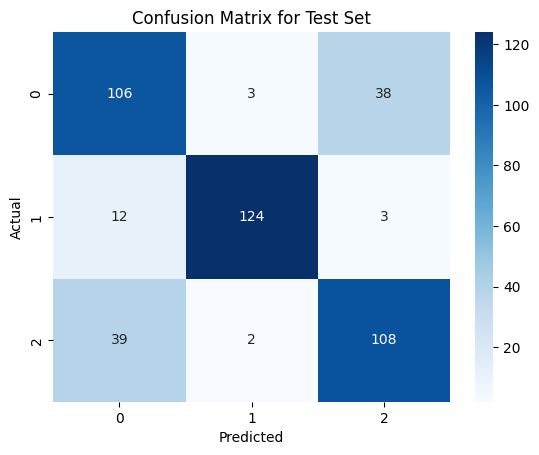

In [ ]:
# Make predictions
y_pred = stacking_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy of Stacking Classifier: {accuracy:.2f}")

precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')

print(f'Precision: {precision * 100:.2f}')
print(f'Recall: {recall * 100:.2f}')
print(f'F1 Score: {f1 * 100:.2f}')

    # Confusion matrix for the test set
test_conf_matrix = confusion_matrix(Y_test, y_pred)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set')
plt.show()
